In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Olivetti faces dataset
faces = fetch_olivetti_faces()
X = faces.data  # Features (images)
y = faces.target  # Labels (person identifiers)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA preserving 99% of variance
pca = PCA(n_components=0.99, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Define the autoencoder architecture
def build_autoencoder(input_dim, encoding_dim, reg_param):
    # Encoder
    input_img = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l2(reg_param))(input_img)
    central = layers.Dense(encoding_dim // 2, activation='relu')(encoded)
    
    # Decoder
    decoded = layers.Dense(encoding_dim, activation='relu')(central)
    output_img = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder model
    autoencoder = models.Model(inputs=input_img, outputs=output_img)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

# K-fold cross-validation setup
kf = KFold(n_splits=5)

# Hyperparameters to test
learning_rates = [0.001, 0.01]
reg_params = [0.001, 0.01]
encoding_dims = [128, 64] 

# Store the performance
results = []

# Run K-fold cross-validation
for lr in learning_rates:
    for reg in reg_params:
        for enc_dim in encoding_dims:
            fold_results = []
            for train_idx, val_idx in kf.split(X_pca):
                # Build the autoencoder model
                autoencoder = build_autoencoder(X_pca.shape[1], enc_dim, reg)

                # Compile the model with the specified learning rate
                autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

                # Train the model
                history = autoencoder.fit(X_pca[train_idx], X_pca[train_idx],
                                          epochs=50, batch_size=32, 
                                          validation_data=(X_pca[val_idx], X_pca[val_idx]),
                                          verbose=0)
                
                # Store the validation loss
                fold_results.append(history.history['val_loss'][-1])
            
            # Average validation loss across folds
            avg_val_loss = sum(fold_results) / len(fold_results)
            results.append((lr, reg, enc_dim, avg_val_loss))

# Find the best combination of hyperparameters
best_params = min(results, key=lambda x: x[3])
print("Best Hyperparameters: ", best_params)


Best Hyperparameters:  (0.001, 0.001, 64, 15.86994514465332)


Epoch 1/50
13/13 [==============================] - 0s 1ms/step - loss: 16.5366
Epoch 2/50
13/13 [==============================] - 0s 1ms/step - loss: 16.2369
Epoch 3/50
13/13 [==============================] - 0s 1ms/step - loss: 16.0153
Epoch 4/50
13/13 [==============================] - 0s 1ms/step - loss: 15.8510
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 15.7333
Epoch 6/50
13/13 [==============================] - 0s 1ms/step - loss: 15.6409
Epoch 7/50
13/13 [==============================] - 0s 1ms/step - loss: 15.5681
Epoch 8/50
13/13 [==============================] - 0s 1ms/step - loss: 15.5077
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 15.4565
Epoch 10/50
13/13 [==============================] - 0s 1ms/step - loss: 15.4139
Epoch 11/50
13/13 [==============================] - 0s 2ms/step - loss: 15.3756
Epoch 12/50
13/13 [==============================] - 0s 2ms/step - loss: 15.3414
Epoch 13/50
13/13 [==================

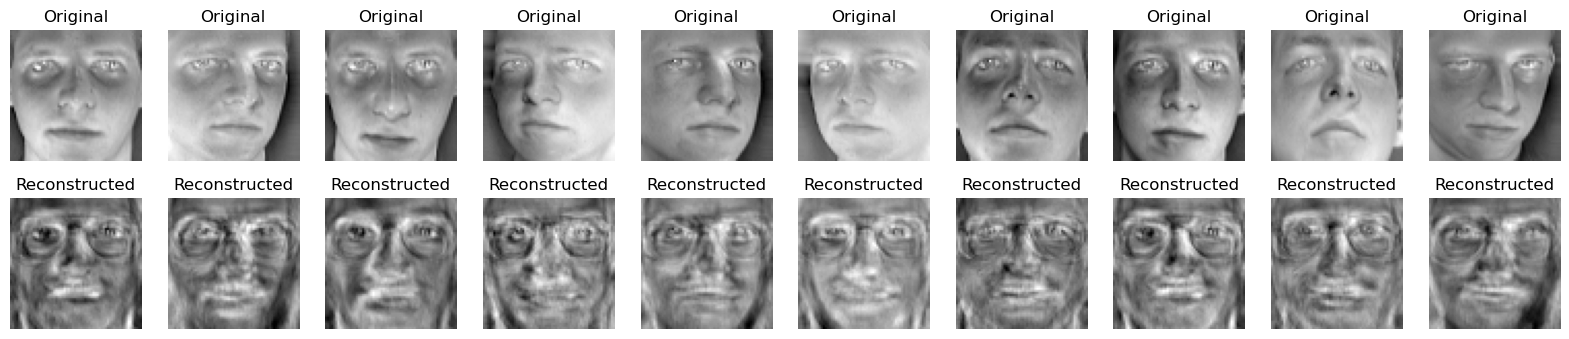

In [5]:
import matplotlib.pyplot as plt

# Build the best autoencoder with optimal hyperparameters
best_autoencoder = build_autoencoder(X_pca.shape[1], 64, 0.001)
best_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the model on the entire training set 
history = best_autoencoder.fit(X_pca, X_pca, epochs=50, batch_size=32, verbose=1)

# Reconstruct the test images 
reconstructed_imgs = best_autoencoder.predict(X_pca)

# Inverse transform the reconstructed images back to original space
reconstructed_imgs_original_space = pca.inverse_transform(reconstructed_imgs)

# Display original and reconstructed images for the test set
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_scaled[i].reshape(64, 64), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs_original_space[i].reshape(64, 64), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
